In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import pickle

from torchvision.models import vgg16, VGG16_Weights
from torchvision import transforms
from PIL import Image
import torch

from helpers import *
import database as Database

In [2]:
# Main
card_dirs = os.listdir("cards/")

create_homography_for_all_cards(card_dirs)
calculate_features_for_all_cards(card_dirs)

# THIS WILL RESET THE DATABASe
database = Database.Database()
# THE ABOVE WILL RESET THE DATABASE

#database = load_database()
database.add_new_cards()
save_database(database)

In [3]:
# Reload Database Object and save
sorted_cards = database.sorted_cards
card_groups = database.card_groups
database = Database.Database()
database.sorted_cards = sorted_cards
database.card_groups = card_groups
save_database(database)

In [4]:
def get_group_to_cards(database):
    group_to_cards = {}
    for k,v in database.card_groups.items():
        if v in group_to_cards:
            group_to_cards[v].append(k)
        else:
            group_to_cards[v] = [k]

    return group_to_cards

def visualise_group(database, group, group_to_cards):
    group_i = group_to_cards[group]
    for i, path in enumerate(group_i):
        plt.subplot(1, len(group_i), i+1)
        image = Image.open(f"homography_cards/{path}")
        plt.axis("off")
        plt.imshow(image)
    
    plt.show()

There are 3 cards that you have duplicates of:
['20230507_013202.jpg', '20230507_013207.jpg']


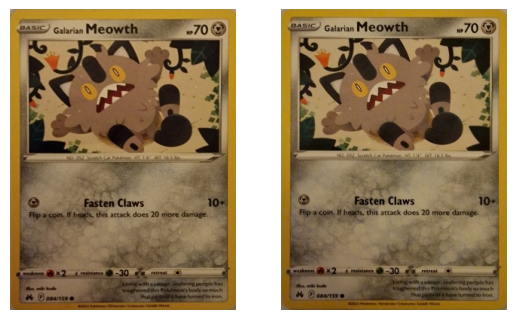

['20230507_013221.jpg', '20230507_013225.jpg']


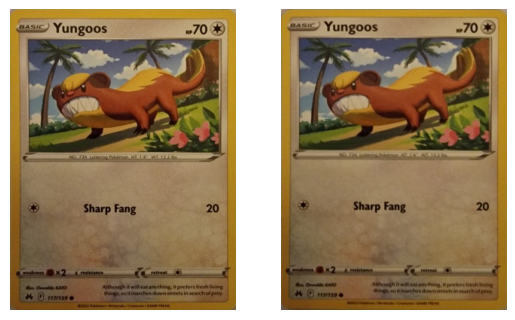

['20230507_013359.jpg', '20230507_013402.jpg']


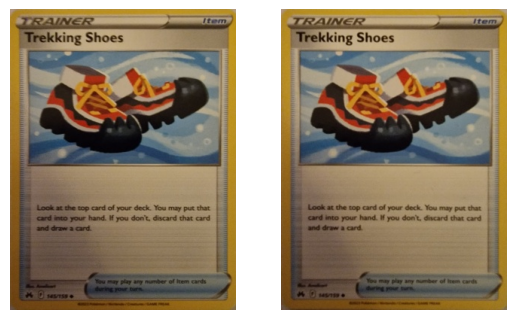

In [7]:
# Show all copies of multiple cards
group_to_cards = get_group_to_cards(database)
multi_card_groups = [k for k,v in group_to_cards.items() if len(v) > 1]
print(f"There are {len(multi_card_groups)} cards that you have duplicates of:")
for group in multi_card_groups:
    print(group_to_cards[group])
    visualise_group(database, group, group_to_cards)